# Edward Vuong - 20115097

## Introduction 
### This project aims to design, train, and evaluate a Convolutional Neural Network (CNN) to identify handwritten digits from the n-MNIST dataset. This dataset is a tougher version of the usual MNIST, as the digits are blurred to mimic camera shake, making them harder to classify

### First I import all necessary libraries 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import csv
from torch import optim
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(88)

### Then, I set up two separate PyTorch Dataset classes: one for training data and one for testing data. This approach is directly uses the code structure provided in task8.2 from workshop 8. Each class has a size parameter with the right default value

In [2]:
# Import torch.utils.data to use Dataset
import torch.utils.data as data

# Training Dataset Class
class nMNIST_Dataset(data.Dataset):
    
    def __init__(self, size=60000):
        """
        Inputs:
            size - number of digit images, n-MNIST train has 60000
        """
        super().__init__()
        self.size = size
        self.load_data()
        self.T = transforms.ToTensor()  # Transform from numpy to torch tensor

    def load_data(self):
        # This method loads the full 60000 training images
        nTrain = 60000
        img_data = np.zeros((nTrain,28,28))
        label_data = np.zeros((nTrain, 10))
        with open('./n-MNIST/trainx.csv', 'r') as csv_file:
            csvreader = csv.reader(csv_file)
            for i,data in enumerate(csvreader):
                img = np.array(data, dtype='int64')
                img_data[i] = img.reshape((28,28))
        with open('./n-MNIST/trainy.csv', 'r') as csv_file:
            csvreader = csv.reader(csv_file)
            for i,data in enumerate(csvreader):
                label = np.array(data, dtype='int64')
                label_data[i] = label
        
        self.data = img_data
        self.label = label_data
        
    def __len__(self):
        # The length is determined by the size parameter passed during initialization
        return self.size
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        data_point = self.T(data_point).to(torch.float32)
        data_label = torch.tensor(data_label).argmax()
        return data_point, data_label

# Test Dataset Class
class nMNIST_Dataset_Test(data.Dataset):
    
    def __init__(self, size=10000):
        """
        Inputs:
            size - number of digit images, n-MNIST test has 10000
        """
        super().__init__()
        self.size = size
        self.load_data()
        self.T = transforms.ToTensor() # Transform from numpy to torch tensor

    def load_data(self):
        # This method loads the full 10000 test images
        nTest = 10000
        img_data = np.zeros((nTest,28,28))
        label_data = np.zeros((nTest, 10))
        with open('./n-MNIST/testx.csv', 'r') as csv_file:
            csvreader = csv.reader(csv_file)
            for i,data in enumerate(csvreader):
                img = np.array(data, dtype='int64')
                img_data[i] = img.reshape((28,28))
        with open('./n-MNIST/testy.csv', 'r') as csv_file:
            csvreader = csv.reader(csv_file)
            for i,data in enumerate(csvreader):
                label = np.array(data, dtype='int64')
                label_data[i] = label
        
        self.data = img_data
        self.label = label_data
        
    def __len__(self):
        # The length is determined by the size parameter
        return self.size
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        data_point = self.T(data_point).to(torch.float32)
        data_label = torch.tensor(data_label).argmax()
        return data_point, data_label

### After this, I create DataLoader and Visualizing Data

Train Dataset: 60000 samples, 600 batches
Test Dataset:  10000 samples, 20 batches

Sample images from the n-MNIST training set:


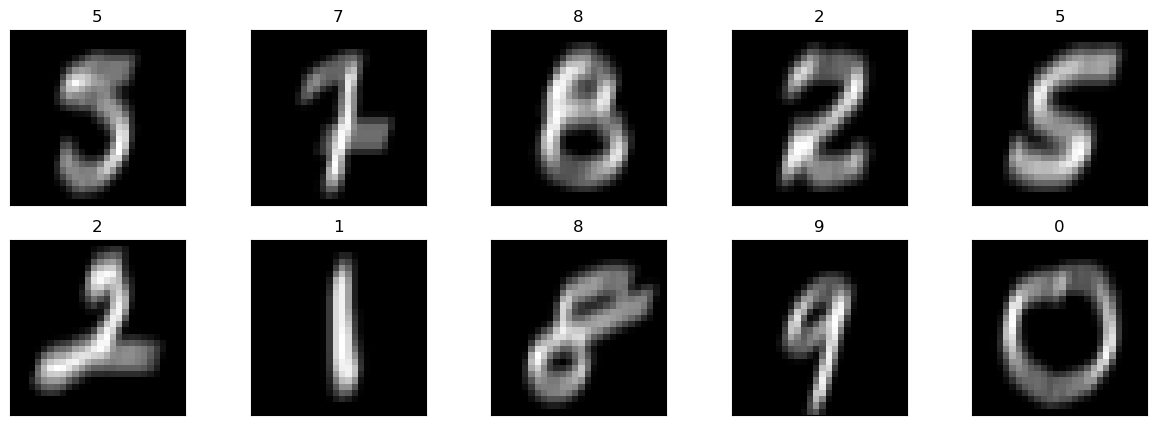

In [3]:
# Load the train and test dataset by calling the respective classes
train_dataset = nMNIST_Dataset()      # Defaults to size=60000
test_dataset = nMNIST_Dataset_Test()  # Defaults to size=10000

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=500, shuffle=False)

# Verify the dataset is correctly created
print(f"Train Dataset: {len(train_dataset)} samples, {len(train_loader)} batches")
print(f"Test Dataset:  {len(test_dataset)} samples, {len(test_loader)} batches")

#Visualize some data
print("\nSample images from the n-MNIST training set:")
data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(15, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(labels[idx].item())
plt.show()

### I success reading the CSV files, reshaping the data 28x28 images and displayihg them with their correspond labels.As I can see, these digits are not clean, they are blury and motion like distortion which is exactly what nMNIST dataset is designed to simulate camera shake:
### - The "5" in the top left corner defines motion blur.
### - The "8" in the bottom row is heavily distored.
### - The "1" is the thicker and less distinct compared to a standard MNIST "1"
### This visual confirmation is the perfect justification why an advanced CNN is needed. A simple CNN struggle with the subtle, noisy patterns in these images. The deeper architecture of the enhanced CNN can learn more abstract and robust features, it is a specially designed to handle more complex data and noisy data

### Model Architecture and Hyperparameters:
### I set up two different CNN architectures to find a good solution.
### Experiment 1: Baseline CNN (from Workshop 8) This is a 2 convolutional layer CNN. It serves as my performance baseline.
### Architecture: Conv -> Pool -> Conv -> Pool -> FC


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x

### Experiment 2: Deeper CNN. To better handle the blurred features of n-MNIST, I propose a deeper and more robust architecture.
### Enhancements:(Task 3) I'm Including an additional convolutional layer (self.conv3) to help the network to learn a more complex hierarchy of features. I increased the number of feature map from 32 to 64 for this new layer (Task 2). Third Convolutional Layer improves classification capability.
### Dropout: For regularization to prevent overfitting. 
### Architecture: Conv -> Pool -> Conv -> Pool -> Conv -> Pool -> FC -> Dropout -> FC. 
### For Task 4, Im also adding an extra fully connected layer (self.fc1) before final output layer (self.fc2)

In [5]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        
        # Layer 1: Conv -> ReLU -> MaxPool
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Layer 2: Conv -> ReLU -> MaxPool
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # Layer 3: Conv -> ReLU -> MaxPool (Additional Layer)
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, 1, 1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        
        # After 3 pooling layers, 28x28 -> 14x14 -> 7x7 -> 3x3.
        # Flattened size = 64 channels * 3 * 3 = 576
        
        # Fully Connected Layers with Dropout
        self.fc1 = nn.Linear(64 * 3 * 3, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output, x

### Then, I make functions to handle training and evaluation loops

In [6]:
def train_and_evaluate(model, num_epochs, train_loader, test_loader, optimizer, loss_fn):
    
    history = {'train_loss': [], 'test_loss': [], 'test_acc': []}
    total_steps = len(train_loader)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            b_x = Variable(images)
            b_y = Variable(labels)
            
            output = model(b_x)[0]
            loss = loss_fn(output, b_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i+1) % 200 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, i+1, total_steps, loss.item()))

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                outputs, _ = model(images)
                loss = loss_fn(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_train_loss = running_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        accuracy = 100 * correct / total
        
        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        history['test_acc'].append(accuracy)
        
        print(f"\n End of Epoch {epoch+1}")
        print(f"Average Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | Test Accuracy: {accuracy:.2f}%\n")

    return history

def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['test_loss'], label='Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Loss vs. Epochs for {title}')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(history['test_acc'], label='Test Accuracy', color='orange')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'Test Accuracy vs. Epochs for {title}')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

## Adjusting the hyperparameters
### -I increased number of training epoches to 5 for both basline CNN and enhanced CNN because the big size of datasets are big, they require more epochs to capture and learn these patterns adaquately. ALlso, they are complex models so additional epochs are needed to convenge and rach their optimal performance. 
### - I keep learning rate as 0.001. because a learning rate between 0.01 to 0.001 is often a good starting point.The higher learning rate, the more risks of overshooting the optimal minimim. 

### Here are results of base line CNN 

Training Baseline CNN
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
Epoch [1/5], Step [200/600], Loss: 0.1168
Epoch [1/5], Step [400/600], Loss: 0.1024
Epoch [1/5], Step [600/600], Loss: 0.0775

 End of Epoch 1
Average Train Loss: 0.2438 | Test Loss: 0.0646 | Test Accuracy: 97.82%

Epoch [2/5], Step [200/600], Loss: 0.0974
Epoch [2/5], Step [400/600], Loss: 0.0732
Epoch [2/5], Step [600/600], Loss: 0.0695

 End of Epoch 2
Average Train Loss: 0.0584 | Test Loss: 0.0494 | Test Accuracy: 98.33%

Epoch [3/5], Step [200/600], Loss: 0.0458
Epoch [3/5], Step [400/600], Loss:

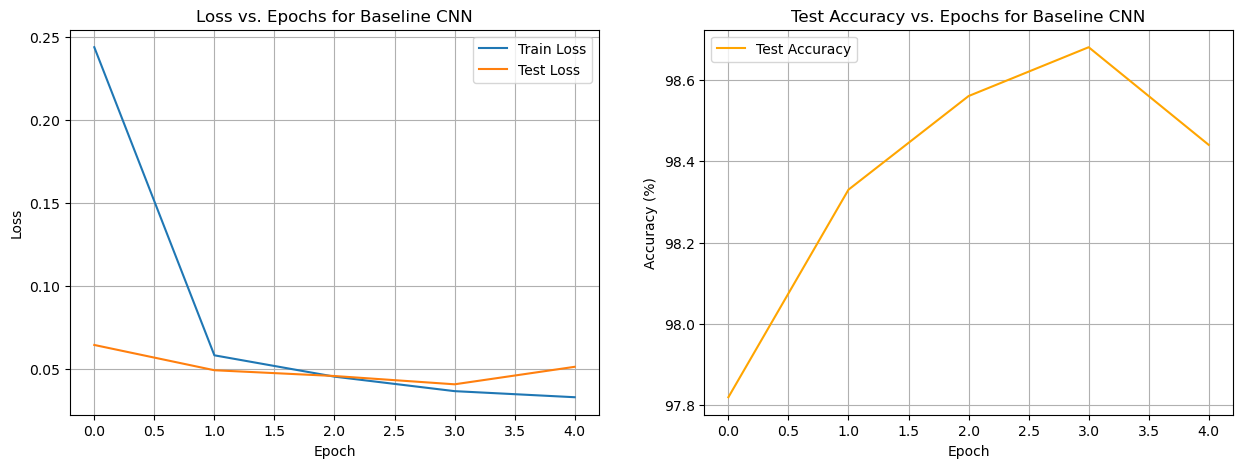

In [7]:
print("Training Baseline CNN")
baseline_cnn = CNN()
print(baseline_cnn)

# Hyperparameters
learning_rate = 0.001
num_epochs_baseline = 5 
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_cnn.parameters(), lr=learning_rate)

# Train the model
baseline_history = train_and_evaluate(baseline_cnn, num_epochs_baseline, train_loader, test_loader, optimizer, loss_fn)

# Plot results
plot_history(baseline_history, "Baseline CNN")

### Baseline CNN Performance
### The graphs for the Baseline CNN show a model that learns quickly but suffers from a classic problem: overfitting.
### Loss vs. Epochs (Left):
### The Train Loss (blue line) drops steadily and continues to decrease throughout training. This indicates the model is successfully learning to minimize error on the training data it sees repeatedly.
### The Test Loss (orange line) initially decreases, reaching its lowest point around Epoch 3. However, The test loss line begins to rise again after Epoch 3. It means that while the model is getting better at fitting the training data, its performance on unseen test data is getting worse. The gap between the blue and orange lines widens, signaling a failure to generalize.
### Test Accuracy vs. Epochs (Right):
### This plot confirms the overfitting. The Test Accuracy increases to a peak of 98.68% at Epoch 3, which corresponds perfectly with the minimum point of the Test Loss.
### After Epoch 3, the accuracy begins to drop and ends at 98.44% at Epoch 4. This indicates that training beyond Epoch 3 negatively affects the model's ability to generalize..

### And here is result of Enhanced CNN


Training Enhanced CNN
EnhancedCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Epoch [1/5], Step [200/600], Loss: 0.1273
Epoch [1/5], Step [400/600], Loss: 0.1374
Epoch [1/5], Step [600/600], Loss: 0.0925

 End of Epoch 1
Average Train Loss: 0.2938 | Test Loss: 0.0479 |

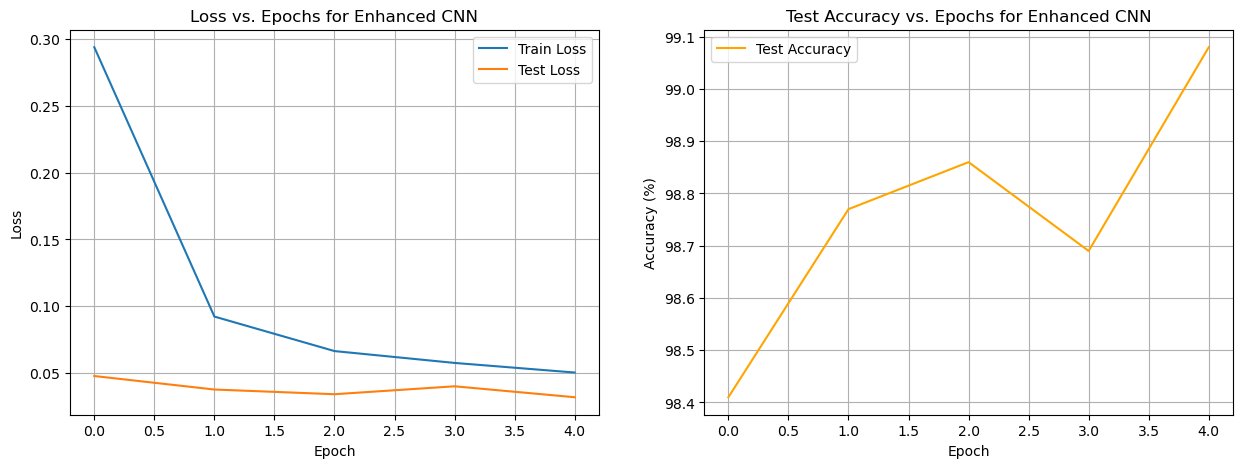

In [8]:
print("\nTraining Enhanced CNN")
enhanced_cnn = EnhancedCNN()
print(enhanced_cnn)

# Hyperparameters
learning_rate = 0.001
num_epochs_enhanced = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(enhanced_cnn.parameters(), lr=learning_rate)

# Train the model
enhanced_history = train_and_evaluate(enhanced_cnn, num_epochs_enhanced, train_loader, test_loader, optimizer, loss_fn)

# Plot results
plot_history(enhanced_history, "Enhanced CNN")

### Enhanced CNN Performance
### The Enhanced CNN demonstrates much better performance and generalization, directly addressing the shortcomings of the baseline model.
### Loss vs. Epochs (Left):
### The Train Loss (blue line) decreases steadily, similar to the baseline.
### However, the key improvement lies in the test loss (orange line), which also decreases and remains consistently low. Unlike the baseline, there is no sharp increase after the initial epochs—indicating strong generalization and minimal overfitting. The model maintains good performance on unseen data throughout training.
### Test Accuracy vs. Epochs (Right):
### The Test Accuracy shows a clear upward trend, reaching a peak of around 99.1% at the final epoch.
### Although there is a drop from Epoch 2 to Epoch 3 (which is normal fluctuation during training, often due to the stochastic nature of the optimizer).After Epoch 3, the model recovers and continues to improve. The fact that the accuracy is still rising at the end suggests the model is robust and might even benefit from further training.


### Conclusion
### By compairing baseline CNN graphs and enhanced CNN graphs, I can justify enhanced CNN generate better solution.
### - Hisghest test accuracy: 99.08%
### - Reduce overfitting: baseline CNN overfits but Enhanced CNN does not, this improvement is a result of architectural changes: Adding an extra convolutional layer which allows model to extract further features from input blury images, drop out encourages the model to develop redundant and robust representations, reducing reliance on specific training features. This is the primary reason the test loss remains low and stable.
### - Improved Robustness: The Enhanced CNN performance is more stable and reliable, its improvement suggest it has leant the underlying patterns of the nMNIST digits, whereas the Baseline model begins to memorize noise.
### In conclusion, the experimental results proved that an achitectural ehancement model provides a good reasonable solution. The additional convolutional layer and drop out regularization allowed enhanced CNN model to solve the overfitting problem, leading to more accurate model.